In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

## The bias correction is apply only on the RSR products, for Ensemble the correction is created using the corrected RSR values

In [2]:
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CHIRPS', '1dy'
product, time_reso = 'GSMaP', '3h'

In [3]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

In [4]:
COMPUTERNAME = os.environ['COMPUTERNAME']
print(f'Computer: {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

Computer: UNIPD_DELL


In [5]:
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')
weibul_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC','Weibull','1dy')

sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

In [6]:
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [7]:
seed = 42
frac = 0.8

Q_80 = METADATA.sample(frac=frac, random_state=seed)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = METADATA.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(METADATA)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 2943
80% DataFrame: 2354
20% DataFrame: 589


In [8]:
print(f'Load {product}')
dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')

print(f'Reading: {dir_in.split('/')[-1]}')
DATA = xr.open_dataset(dir_in)

lats = DATA.lat
lons = DATA.lon
lon2d, lat2d = np.meshgrid(lons, lats)

Sat_year = DATA.year.values

NYs = DATA.NYs.values
CYs = DATA.CYs.values
WYs = DATA.WYs.values

NYd = DATA.NYd.values
CYd = DATA.CYd.values
WYd = DATA.WYd.values

ntime, nlat, nlon = NYd.shape

Load GSMaP
Reading: ITALY_DOWN_GSMaP_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [9]:
N_obs, C_obs, W_obs = [], [], []
for nn in range(len(Q_80)):
    file_ = os.path.join(weibul_base, Q_80.ISO[nn], Q_80.File[nn])
    statistic = pd.read_csv(file_)
    statistic = statistic[(statistic['Year']>=2002)&(statistic['Year']<=2023)].reset_index(drop=True)
    N_obs.extend(statistic.N.values)
    C_obs.extend(statistic.C.values)
    W_obs.extend(statistic.W.values)

In [10]:
NYd_corrected = ART_sta.ISIMIP_QM(N_obs, NYd.flatten())
CYd_corrected = ART_sta.ISIMIP_QM(C_obs, CYd.flatten())
WYd_corrected = ART_sta.ISIMIP_QM(W_obs, WYd.flatten())

In [11]:
NYd_corrected = NYd_corrected.reshape(ntime, nlat, nlon)
CYd_corrected = CYd_corrected.reshape(ntime, nlat, nlon)
WYd_corrected = WYd_corrected.reshape(ntime, nlat, nlon)

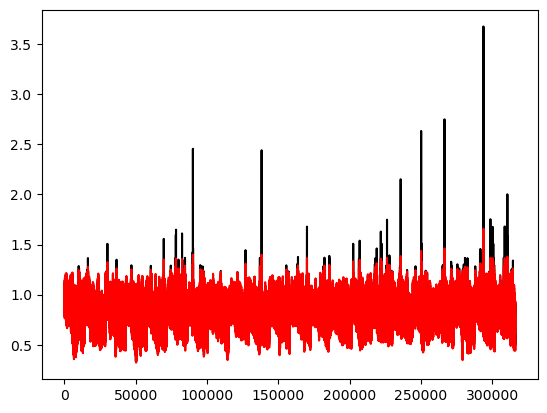

In [12]:
plt.plot(WYd_corrected.flatten(),'k')
plt.plot(WYd.flatten(),'r')

In [13]:
WYd_corrected = np.where(WYd_corrected>1.6,1.6,WYd_corrected)

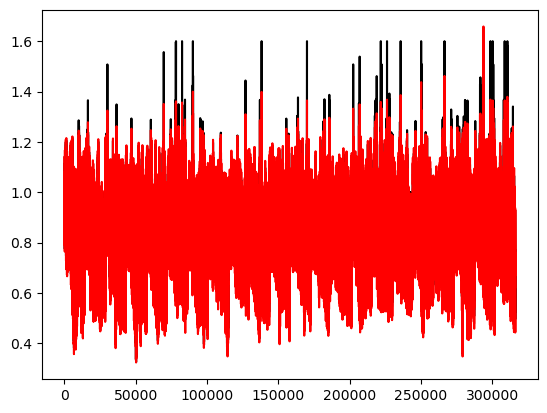

In [14]:
plt.plot(WYd_corrected.flatten(),'k')
plt.plot(WYd.flatten(),'r')

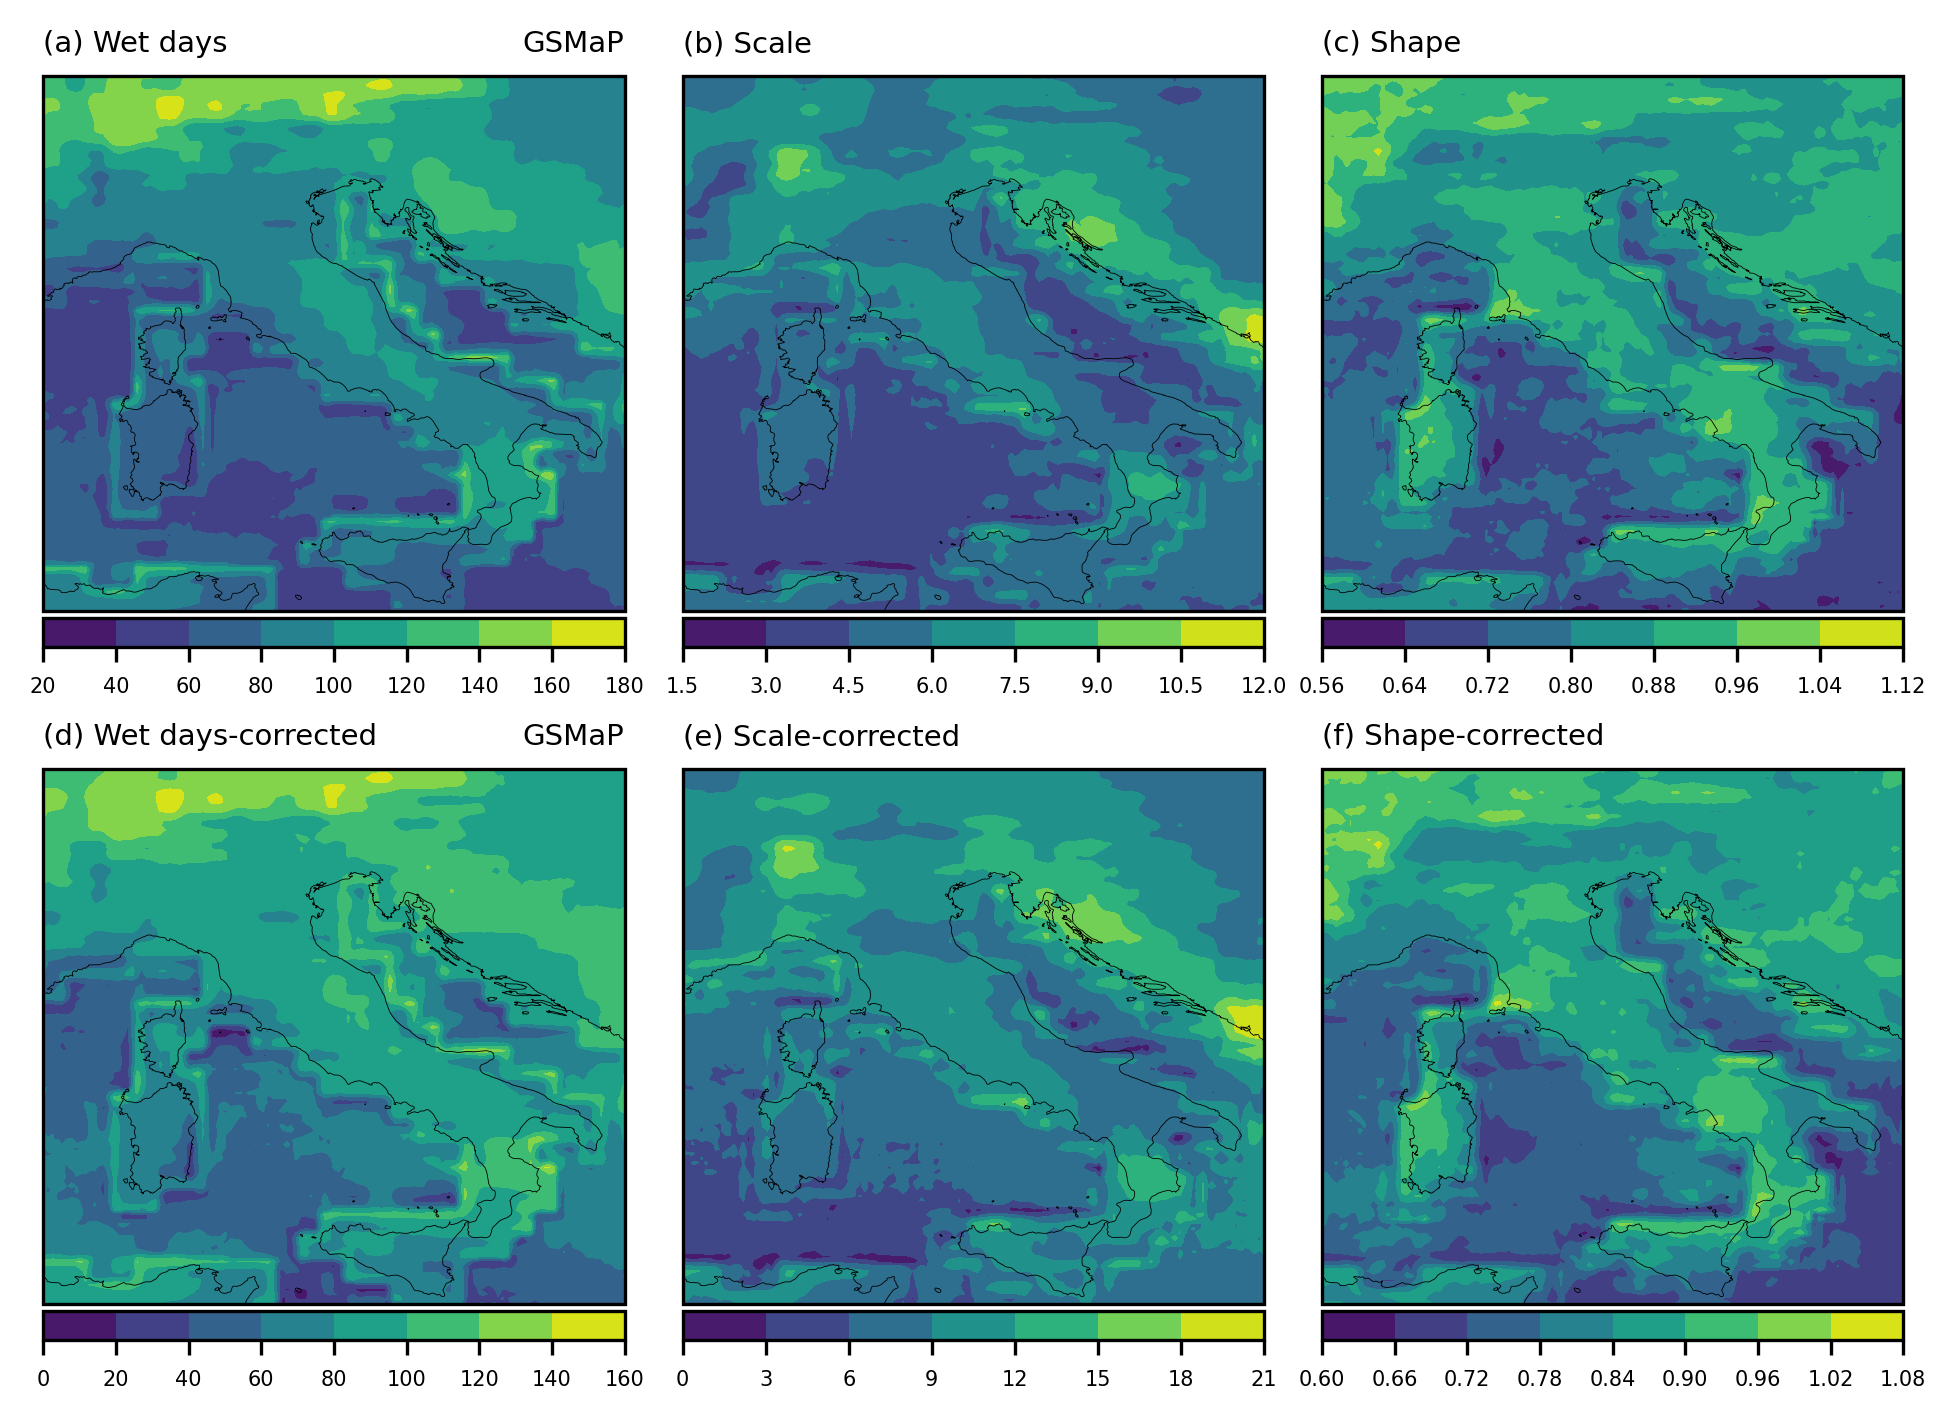

In [15]:
levels_N = np.arange(20,260,20)
levels_C = np.arange(1,43,1)
levels_W = np.arange(0.5,1.6,0.1)

levels_N = None
levels_C = None
levels_W = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,6),dpi=300)
gs = gridspec.GridSpec(2,3)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(NYd,axis=0), levels=levels_N)

ax1.set_title(f'(a) Wet days', fontsize=7, loc='left')
ax1.set_title(f'{product}', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(CYd,axis=0), levels=levels_C)

ax1.set_title(f'(b) Scale', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(WYd,axis=0), levels=levels_W)

ax1.set_title(f'(c) Shape', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(NYd_corrected,axis=0), levels=levels_N)

ax1.set_title(f'(d) Wet days-corrected', fontsize=7, loc='left')
ax1.set_title(f'{product}', fontsize=7, loc='right')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(CYd_corrected,axis=0), levels=levels_C)

ax1.set_title(f'(e) Scale-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.2,color='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(WYd_corrected,axis=0), levels=levels_W)

ax1.set_title(f'(f) Shape-corrected', fontsize=7, loc='left')

cbar = plt.colorbar(a1, ticks= None, orientation='horizontal', pad=0.01, fraction=0.045)
cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [16]:
Mevd_corrected = ART_down.pre_quantiles_array(
                        NYd_corrected, 
                        CYd_corrected, 
                        WYd_corrected, 
                        Tr, 
                        lats, lons,
                        1)

In [17]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "NYd": (("year","lat","lon"), NYd_corrected),
        "CYd": (("year","lat","lon"), CYd_corrected),
        "WYd": (("year","lat","lon"), WYd_corrected),
        "Mev_d": (("Tr","lat","lon"), Mevd_corrected),
    },
    coords={
        'year': Sat_year, 
        'lat': lats, 
        'lon': lons
    },
    attrs=dict(description=f"{product} Weibull parameters corrected applying ISIMIP_QM method using 80% of stations in Italy",)
)

DOWN_corrected.NYd.attrs["units"] = "# days"
DOWN_corrected.NYd.attrs["long_name"] = "Corrected Downscaled Number of Wet Days"
DOWN_corrected.NYd.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYd.attrs["units"] = "nondimensional"
DOWN_corrected.CYd.attrs["long_name"] = "Corrected Downscaled Scale Parameter"
DOWN_corrected.CYd.attrs["origname"] = "Down Scale"

DOWN_corrected.WYd.attrs["units"] = "nondimensional"
DOWN_corrected.WYd.attrs["long_name"] = "Corrected Downscaled Shape Parameter"
DOWN_corrected.WYd.attrs["origname"] = "Down Shape"

DOWN_corrected.Mev_d.attrs["units"] = "mm/day"
DOWN_corrected.Mev_d.attrs["long_name"] = "Corrected Downscaled Extreme Quantiles"
DOWN_corrected.Mev_d.attrs["origname"] = "Down Ext-Quant"

DOWN_corrected.lat.attrs["units"] = "degrees_north"
DOWN_corrected.lat.attrs["long_name"] = "Latitude"

DOWN_corrected.lon.attrs["units"] = "degrees_east"
DOWN_corrected.lon.attrs["long_name"] = "Longitude"

In [18]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
PRE_out = os.path.join(os.path.join(dir_base, '6_DOWN_BCorrected', dir_in.split('/')[-1]))
print(f'Export as: {PRE_out}')
DOWN_corrected.to_netcdf(PRE_out)

Export as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/ITALY_DOWN_GSMaP_3h_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc
